In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

from keras.models import Sequential
from keras.layers import Dense, LSTM

plt.rcParams["figure.figsize"] = (10,6)

In [2]:
# read data (Date already cast to datetime with "parse_dates")

data_directory = "data/"

df = pd.read_csv(data_directory + 'train.csv', parse_dates=['Date']).set_index('Date')
df.head()

,Open,High,Low,Close,Adj Close,Volume,Target
Date,,,,,,,
1994-01-03,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.0,0
1994-01-04,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.0,1
1994-01-05,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,1
1994-01-06,NaN,NaN,NaN,NaN,NaN,NaN,0
1994-01-07,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.0,1


In [3]:
# only Date and Target is non-null, we need to treat the other ones
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6554 entries, 1994-01-03 to 2019-05-30
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       6421 non-null   float64
 1   High       6421 non-null   float64
 2   Low        6421 non-null   float64
 3   Close      6421 non-null   float64
 4   Adj Close  6421 non-null   float64
 5   Volume     6421 non-null   float64
 6   Target     6554 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 409.6 KB


In [4]:
# we see that where a row has any null, the target is always 0...

print("Unique target values on null data:", df[df.isnull().any(axis=1)]['Target'].unique())

# It seems like by now the best option is to drop the empty rows

df = df.dropna()
print(df.info())
df.head()

Unique target values on null data: [0]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6421 entries, 1994-01-03 to 2019-05-30
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       6421 non-null   float64
 1   High       6421 non-null   float64
 2   Low        6421 non-null   float64
 3   Close      6421 non-null   float64
 4   Adj Close  6421 non-null   float64
 5   Volume     6421 non-null   float64
 6   Target     6421 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 401.3 KB
None


,Open,High,Low,Close,Adj Close,Volume,Target
Date,,,,,,,
1994-01-03,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.0,0
1994-01-04,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.0,1
1994-01-05,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,1
1994-01-07,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.0,1
1994-01-10,3655.199951,3678.199951,3655.199951,3660.600098,3660.596436,0.0,1


In [5]:
# new columns for date

df['month'] = df.index.month
df['day_of_month'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['year'] = df.index.year

In [6]:
df.head(25)

,Open,High,Low,Close,Adj Close,Volume,Target,month,day_of_month,day_of_week,year
Date,,,,,,,,,,,
1994-01-03,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.0,0,1,3,0,1994
1994-01-04,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.0,1,1,4,1,1994
1994-01-05,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,1,1,5,2,1994
1994-01-07,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.0,1,1,7,4,1994
1994-01-10,3655.199951,3678.199951,3655.199951,3660.600098,3660.596436,0.0,1,1,10,0,1994
1994-01-11,3679.699951,3712.500000,3679.699951,3712.399902,3712.396240,0.0,1,1,11,1,1994
1994-01-12,3712.300049,3712.300049,3675.899902,3680.100098,3680.096436,0.0,1,1,12,2,1994
1994-01-13,3680.100098,3698.199951,3670.399902,3680.800049,3680.796387,0.0,1,1,13,3,1994
1994-01-14,3680.800049,3737.399902,3662.899902,3736.399902,3736.395996,0.0,1,1,14,4,1994


<AxesSubplot:xlabel='Date', ylabel='Volume'>

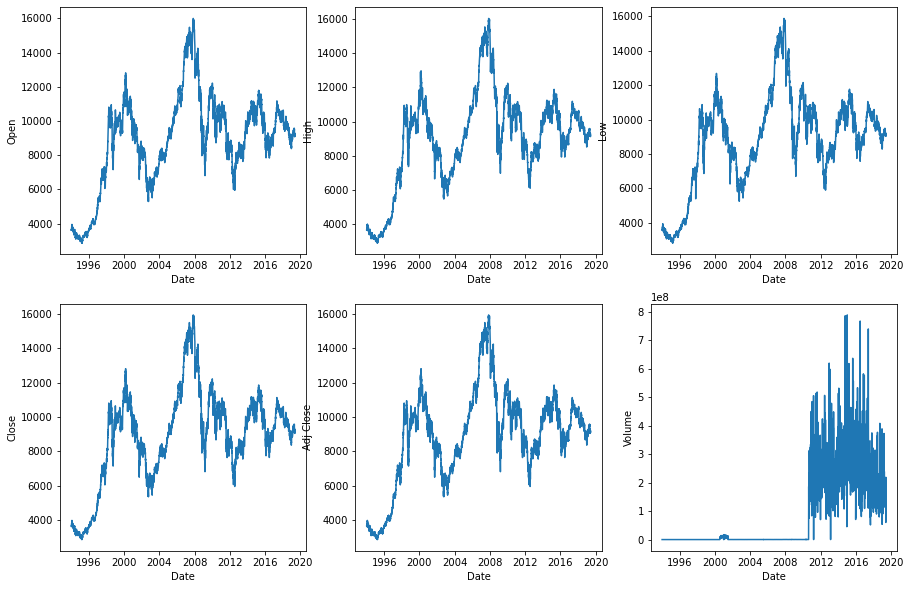

In [7]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))

sns.lineplot(x=df.index, y='Open', data=df, ax=axs[0,0])
sns.lineplot(x=df.index, y='High', data=df, ax=axs[0,1])
sns.lineplot(x=df.index, y='Low', data=df, ax=axs[0,2])

sns.lineplot(x=df.index, y='Close', data=df, ax=axs[1,0])
sns.lineplot(x=df.index, y='Adj Close', data=df, ax=axs[1,1])
sns.lineplot(x=df.index, y='Volume', data=df, ax=axs[1,2])


<AxesSubplot:xlabel='Date'>

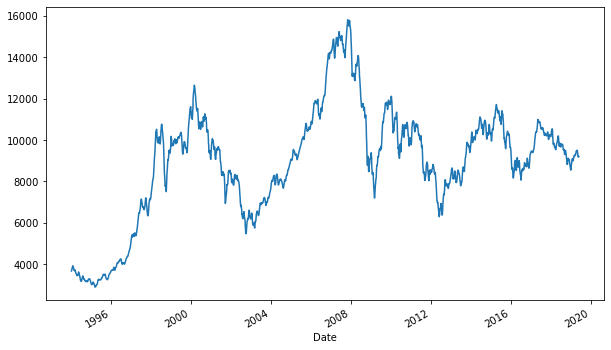

In [8]:
df['Open'].rolling(window=10).mean().plot()

<AxesSubplot:xlabel='Date'>

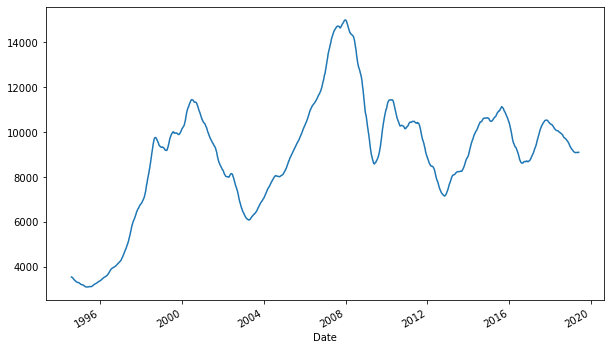

In [9]:
df['Open'].rolling(window=150).mean().plot()

<AxesSubplot:>

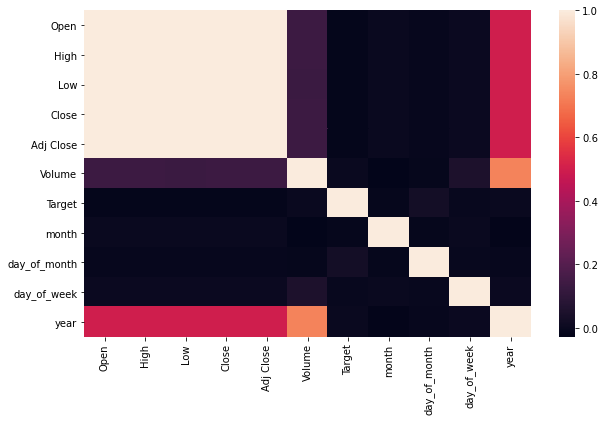

In [10]:
sns.heatmap(df.corr())

In [17]:
new_data = df.filter(['Close','Target'])#.values
new_data

,Close,Target
Date,,
1994-01-03,3654.500000,0
1994-01-04,3630.300049,1
1994-01-05,3621.199951,1
1994-01-07,3636.399902,1
1994-01-10,3660.600098,1
...,...,...
2019-05-24,9174.599609,0
2019-05-27,9216.400391,0
2019-05-28,9191.799805,0


In [18]:
len(new_data)

6421

In [116]:
len_train_data = round(len(new_data) * 0.7)

X_train = new_data[:len_train_data]
X_test = new_data[len_train_data:]

y_train = X_train['Target'].copy()
y_test = X_test['Target'].copy()

X_train.drop(columns=['Target'], inplace=True)
X_test.drop(columns=['Target'], inplace=True)

In [117]:
y_test.shape

(1926,)

In [118]:

# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)

# X_train

In [119]:
def reshape_timeseries_data(X, y, time_steps):
    X_dataset = []
    y_dataset = []
    
    for i in range(len(X) - time_steps):
        X_dataset.append(X[i:i+time_steps])
        y_dataset.append(y[i:i+time_steps])
    
    return np.array(X_dataset), np.array(y_dataset)

In [120]:
y_test.shape

(1926,)

In [121]:
TIME_STEPS = 20
X_train, y_train = reshape_timeseries_data(X_train, y_train.values, TIME_STEPS)
X_test, y_test = reshape_timeseries_data(X_test.values, y_test.values, TIME_STEPS)

In [122]:
y_test.shape

(1906, 20)

In [123]:
X_train.shape[-1]

1

In [124]:
# Model LSTM

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (TIME_STEPS, X_train.shape[-1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))



In [125]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [126]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

4475/4475 [==============================] - 35s 7ms/step - loss: 0.2729


In [127]:
predictions = model.predict(X_test)

In [77]:
rmse = np.sqrt(np.mean(predictions - y_test) **2)

In [78]:
rmse

3.696086811293835

In [86]:
X_test.shape

(1926, 1)

In [84]:
new_data[len_train_data:].shape

(1926, 2)

In [115]:
train = X_train#new_data[:len_train_data]
valid = y_train#new_data[len_train_data:]
valid['Predictions'] = np.squeeze(predictions)

plt.figure(figsize=(18,8))
plt.title('model')
plt.xlabel('Date')
plt.ylabel('Closing price')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [128]:
predictions

array([[0.497017],
       [0.497017],
       [0.497017],
       ...,
       [0.497017],
       [0.497017],
       [0.497017]], dtype=float32)